# Capston Project: Analytic Report & Research Proposal

In [50]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
import itertools
%matplotlib inline

In [51]:
w = pd.read_csv('https://raw.githubusercontent.com/borja876/Thinkful-DataScience-Borja/master/Electricity%20Consumption.csv')
x = pd.read_csv('https://raw.githubusercontent.com/borja876/Thinkful-DataScience-Borja/master/GDP%20current%20prices.csv')
y = pd.read_csv('https://raw.githubusercontent.com/borja876/Thinkful-DataScience-Borja/master/Population.csv')

In [52]:
df = pd.DataFrame(w)
df1 = pd.DataFrame(x)
df2 = pd.DataFrame(y)

# Data sets decription

Three data sets have been imported from the UN database. The data sets contain global information for the time span 2000-2014 regarding:

1. Electricity consumption for the household market (GhW). In this dataset, the UN has estimated values for some countries (ex-colonies of the UK) based on their April-March consumption. This estimation has been done up until 2004 yearly electricity consumption was standardized following the natural year and not the fiscal year. Electricity consumption in Iraq in 2014 has a null value, as it was not reported due to the war that started in 2015.
2. GDP per country in current USD. From all the data sets available, measuring GDP the one measuring it in current USD has been chosen to avoid the impact of the different base years across countries when calculating the base of the deflation year and to avoid the use of different exchange rates across countries during the time span under analysis.
3. Population. In this case, the population has been converted into (Thousands) as a unit to make the standardized GDP and electricity consumption significant. This variable shows the net population at the end of the year considering births, deaths and declared migration.

The three of them are significant because, although different data sets containing these sets of information exist, only a few are gathered by the same institution (UN) and are consistent so that they can be compared against each other reducing the noise that may exist in the data due to different data gathering technics used across countries.
Electricity consumption and GDP are two metrics that measure the wealth and wellbeing of a country. Its evolution during years can not only show where economy has experienced a slowdown and lose of welfare. The chosen time span neutralizes the effect of the disappearance of the USSR not distorting the obtained results. Furthermore, the evolution of these two variables before the year 2000 are not representative predicting the future evolution of the wealth and wellbeing in a country/continent or its economic slowdown. The main reason being that the way in which the information is gathered in both cases has changed at a macroeconomic level and base years have been adjusted to the year 2000.

Both variables have been analyzed after standardizing them considering the Population as the common factor. Additionally, they have been rescaled to kWh (electricity consumption) and (Million USD) to make them comparable. Household electricity consumption per individual and GDP per individual at current prices are better proxies of the welfare of the country and scaling issues disappear.

In [53]:
#Cleanse Data Frame Electricity Consumption:
#Take out rows without countries
#Rename columns
#Clean columns taking out those that are not used
dfa= df[:3206]
dfb= dfa.rename(columns={'Country or Area': 'Country', 'Quantity': 'Household Consumption (GWh)'})
dfc = dfb.drop(["Quantity Footnotes", "Unit", "Commodity - Transaction"], axis=1)
dfc['Year'] = dfc['Year'].astype(int)

In [54]:
dfc.loc[dfc['Household Consumption (GWh)'] == 0]

,Country,Year,Household Consumption (GWh)
1403,Iraq,2004,0.0


In [55]:
#Cleanse Data Frame GDP Current Prices (USD):
#Take out rows without countries
#Rename columns
#Clean columns taking out those that are not used
dfd= df1[:3322]
dfe= dfd.rename(columns={'Country or Area': 'Country', 'Value': 'GDP Current Prices (USD)'})
dfg = dfe.drop('Value Footnotes', axis=1)
dfg['Year'] = dfg['Year'].astype(int)

In [56]:
dfg.loc[dfg['GDP Current Prices (USD)'] == 0]

,Country,Year,GDP Current Prices (USD)


In [57]:
#Cleanse Data Frame Population:
#Take out rows without countries
#Rename columns
#Clean columns taking out those that are not used
dfh= df2[:3522]
dfi= dfh.rename(columns={'Country or Area': 'Country', 'Value': 'Population'})
dfj = dfi.drop('Value Footnotes', axis=1)
dfj['Year'] = dfj['Year'].astype(int)

In [58]:
dfj.loc[dfj['Population'] == 0]

,Country,Year,Population


In [59]:
#Merge data into a single dataset
result = dfc.merge(dfg, left_on=["Country","Year"], right_on=["Country","Year"], how='outer')

In [60]:
result = result.merge(dfj, left_on=["Country","Year"], right_on=["Country","Year"], how='outer')

In [61]:
#Cleanse new dataset
result = result.dropna()

In [62]:
result['GDP Current Prices (Million USD)']=result['GDP Current Prices (USD)']/1000000
result['Population (Thousands)']=result['Population']/1000

In [63]:
result = result.drop('GDP Current Prices (USD)',1)
result = result.drop('Population',1)
result= result.rename(columns={'GDP Current Prices (USD)': 'GDP Current Prices (Million USD)', 'Population': 'Population (Thousands)'})

In [64]:
#Use population as a common ground to standardise GDP and household consumption so that both are comparable
result['Standard GDP Current Prices (USD)'] =(result['GDP Current Prices (Million USD)']*1000)/result['Population (Thousands)']
result['Standard Household Consumption (x10 kWh)'] = (result['Household Consumption (GWh)']*1000)/result['Population (Thousands)']

A list of countries per continent has been imported from a different source. The use of this list aims to group by continent the information provided by the UN at a country level. This has risen additional difficulties due to the use different names between sources for several countries, for example: Russian Federation vs. Russia, Netherlands vs. The Netherlands, etc. Additional countries not considered in the list have been added so that all continents are accurately represented. In this case, America has been split into North and South America to have a detailed view of the evolution of both regions independently and to avoid distortion.

In [65]:
%run countries.py

In [66]:
#Create list of countries within continents and populate
regions = {}
for country in countries:
    regions[country['name']] = country["continent"]
    
#Incorporate to the data set the continent in which the country is
result["Continent"] = result["Country"].apply( lambda x: regions[x] if x in regions.keys() else None)

It has been checked that all countries considered by the UN are captured in the list of countries used to group them by continent.

In [67]:
resulta = result[result['Continent'].isnull()]
resultb=resulta.drop_duplicates('Country')
resultb

,Country,Year,Household Consumption (GWh),GDP Current Prices (Million USD),Population (Thousands),Standard GDP Current Prices (USD),Standard Household Consumption (x10 kWh),Continent


The following table shows the first five rows of the final data set that will be used for the purpose of this report:

In [68]:
result.head()

,Country,Year,Household Consumption (GWh),GDP Current Prices (Million USD),Population (Thousands),Standard GDP Current Prices (USD),Standard Household Consumption (x10 kWh),Continent
0,Afghanistan,2014,2204.9,20050.189882,31627.506,633.947864,69.714634,Asia
1,Afghanistan,2013,1633.5,20046.334304,30682.500,653.347488,53.238817,Asia
2,Afghanistan,2012,1922.0,20536.542737,29726.803,690.842629,64.655456,Asia
3,Afghanistan,2011,1145.0,17930.239400,28809.167,622.379654,39.744294,Asia
4,Afghanistan,2010,1387.0,15936.800636,27962.207,569.940729,49.602665,Asia


The following summary statistics have been conducted. In the table below, it can be seen the difference between extreme values for all variables, ranging from zero/tens to millions before the variables electricity consumption and GDP have been standardized. Once standardized, values dispersion continues to be high. This strongly recommends the use of the median instead of the mean to avoid the effect of these extreme values. These extreme values come from United States (North America) which is equivalent to the whole Europe and Iraq (min) as zero for 2014.

In [69]:
summary = result.describe().astype(int)
summary.drop('Year',1)

,Household Consumption (GWh),GDP Current Prices (Million USD),Population (Thousands),Standard GDP Current Prices (USD),Standard Household Consumption (x10 kWh)
count,2404,2404,2404,2404,2404
mean,26023,326057,37446,12850,997
std,115527,1301789,143007,18533,1323
min,0,13,9,106,0
25%,272,4350,1368,1140,143
50%,2406,19344,7144,4429,499
75%,12578,137276,21120,15912,1363
max,1445712,17348071,1364270,116612,8475


In [70]:
result.var()

Year                                        1.847723e+01
Household Consumption (GWh)                 1.334670e+10
GDP Current Prices (Million USD)            1.694657e+12
Population (Thousands)                      2.045109e+10
Standard GDP Current Prices (USD)           3.435078e+08
Standard Household Consumption (x10 kWh)    1.752481e+06
dtype: float64

The values of Skewness and Kurtosis, that the variables could not be following a normal distribution.

In [71]:
result.skew()

Year                                       -0.008579
Household Consumption (GWh)                 9.800624
GDP Current Prices (Million USD)            8.459981
Population (Thousands)                      7.751410
Standard GDP Current Prices (USD)           2.198712
Standard Household Consumption (x10 kWh)    2.473069
dtype: float64

In [72]:
result.kurt()

Year                                         -1.201923
Household Consumption (GWh)                 106.408612
GDP Current Prices (Million USD)             84.836854
Population (Thousands)                       63.192716
Standard GDP Current Prices (USD)             5.364767
Standard Household Consumption (x10 kWh)      7.510758
dtype: float64

A closer look at each of the variables confirms what was anticipated by the Skewness and Kurtosis coefficients. When each of the variables is compared against a normal distribution, none of them follow this kind of distribution.

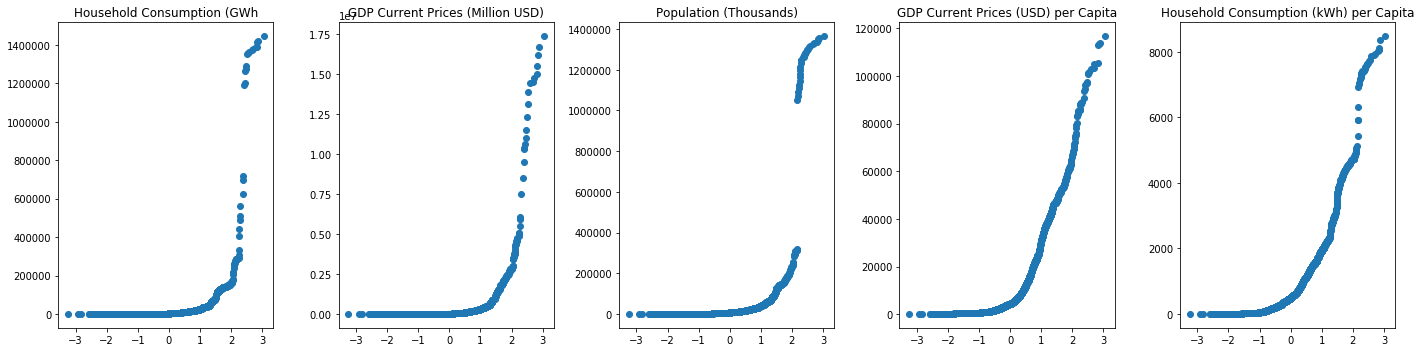

In [73]:
# Making two variables.
norm = np.random.normal(0, 1, 2404)
norm.sort()
a = result.sort_values('Household Consumption (GWh)',ascending=True)
b = result.sort_values('GDP Current Prices (Million USD)',ascending=True)
c = result.sort_values('Population (Thousands)',ascending=True)
d = result.sort_values('Standard GDP Current Prices (USD)',ascending=True)
e = result.sort_values('Standard Household Consumption (x10 kWh)',ascending=True)

#Checking that variables are not normally distributed
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.plot(norm,a['Household Consumption (GWh)'], "o") 
plt.title('Household Consumption (GWh')

plt.subplot(1, 5, 2)
plt.plot(norm,b['GDP Current Prices (Million USD)'], "o") 
plt.title('GDP Current Prices (Million USD)')

plt.subplot(1, 5, 3)
plt.plot(norm,c['Population (Thousands)'], "o") 
plt.title('Population (Thousands)')

plt.subplot(1, 5, 4)
plt.plot(norm,d['Standard GDP Current Prices (USD)'], "o") 
plt.title('GDP Current Prices (USD) per Capita')

plt.subplot(1, 5, 5)
plt.plot(norm,e['Standard Household Consumption (x10 kWh)'], "o") 
plt.title('Household Consumption (kWh) per Capita')

plt.tight_layout()
plt.show()

From the histograms below, it can be seen that the distribution of values is asymmetric, having a high concentration of values in the lower end and a long tail with less occurrence. The standardized variables follow the same pattern in terms of frequency of occurrence between lower and higher values.

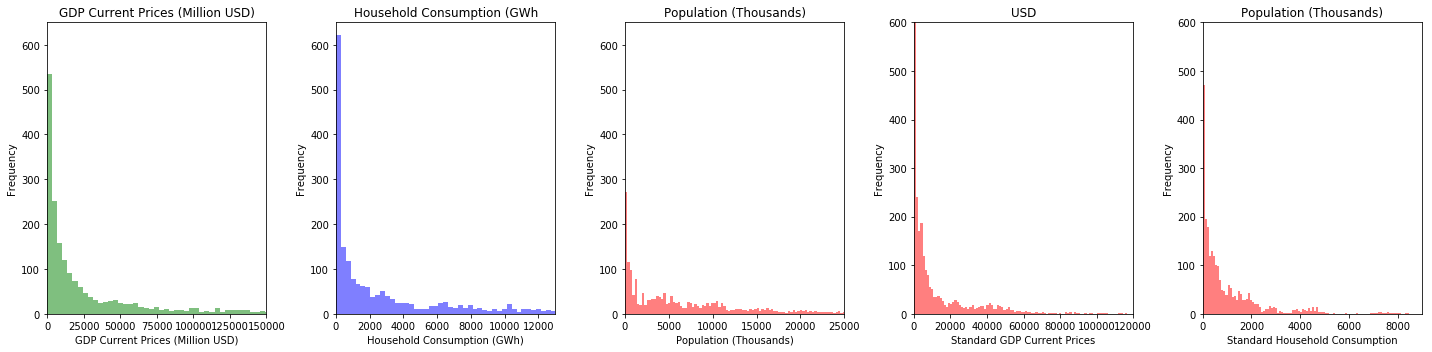

In [74]:
#Histograms
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.xlabel("GDP Current Prices (Million USD)")
plt.ylabel("Frequency")
plt.hist(result['GDP Current Prices (Million USD)'], bins= 5000 ,facecolor='green', alpha=0.5)
plt.axis([0, 150000, 0, 650])
plt.title('GDP Current Prices (Million USD)')

plt.subplot(1, 5, 2)
plt.xlabel("Household Consumption (GWh)")
plt.ylabel("Frequency")
plt.hist(result['Household Consumption (GWh)'], bins=5000 ,facecolor='blue', alpha=0.5)
plt.axis([0, 13000, 0, 650])
plt.title('Household Consumption (GWh')

plt.subplot(1, 5, 3)
plt.xlabel("Population (Thousands)")
plt.ylabel("Frequency")
plt.hist(result['Population (Thousands)'], bins=5000 ,facecolor='red', alpha=0.5)
plt.axis([0, 25000, 0, 650])
plt.title('Population (Thousands)')

plt.subplot(1, 5, 4)
plt.xlabel("Standard GDP Current Prices")
plt.ylabel("Frequency")
plt.hist(result['Standard GDP Current Prices (USD)'], bins=100 ,facecolor='red', alpha=0.5)
plt.axis([0, 120000, 0, 600])
plt.title('USD')

plt.subplot(1, 5, 5)
plt.xlabel("Standard Household Consumption")
plt.ylabel("Frequency")
plt.hist(result['Standard Household Consumption (x10 kWh)'], bins=100 ,facecolor='red', alpha=0.5)
plt.axis([0, 9000, 0, 600])
plt.title('Population (Thousands)')

plt.tight_layout()
plt.show()

# Question 1: Is there a relationship between GDP and Household Consumption? Is it the same in all continents?

When comparing the data sets without grouping the data into continents, the correlation matrix below shows that there is no correlation between years and GDP and Electricity consumption, hence there is no inflation effect on the variables. Additionally it highlights the positive and strong relationship between electricity consumption and GDP. Furthermore, if evidences the relationship between our standardized variables: in the same direction but at a lower rate due to the impact in the variable “Population” used to standardized them.

It also evidences the positive relationship between population and electricity consumption. As expected if shows that only half of the increase is due to an increase in population leaving the other half unexplained.

In [75]:
result.corr()

,Year,Household Consumption (GWh),GDP Current Prices (Million USD),Population (Thousands),Standard GDP Current Prices (USD),Standard Household Consumption (x10 kWh)
Year,1.000000,0.026306,0.069377,0.013221,0.160749,0.019390
Household Consumption (GWh),0.026306,1.000000,0.968013,0.415895,0.201296,0.262330
GDP Current Prices (Million USD),0.069377,0.968013,1.000000,0.403854,0.258789,0.255487
Population (Thousands),0.013221,0.415895,0.403854,1.000000,-0.058557,-0.059805
Standard GDP Current Prices (USD),0.160749,0.201296,0.258789,-0.058557,1.000000,0.730365
Standard Household Consumption (x10 kWh),0.019390,0.262330,0.255487,-0.059805,0.730365,1.000000


For a more granular inspection of the data, median from the standardized variables will be used based on the initial findings regarding the disparity of values in the original data sets. Furthermore, and due to the representativeness of the standardized values, only those will be used to analyze the data per continent. The following charts show the values per continent of the standardized variables. As it can be appreciated there is a significant difference in values between continents, both in the standard houshold consumption and in the GDP.

In [76]:
result1=result.groupby(['Continent','Year']).median()

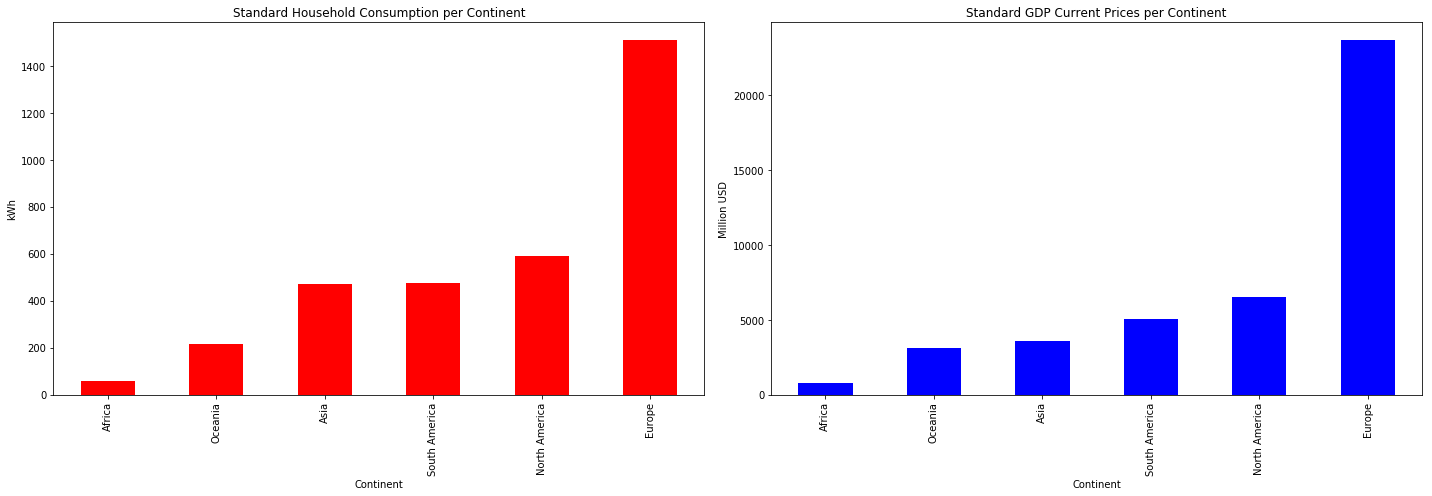

In [77]:
result2=result.groupby(['Continent']).median()
result3 = result2.sort_values(['Standard Household Consumption (x10 kWh)'])

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)

result3['Standard Household Consumption (x10 kWh)'].plot(kind='bar', color='red')
plt.ylabel('kWh')
plt.title('Standard Household Consumption per Continent')

plt.subplot(1, 2, 2)
result3['Standard GDP Current Prices (USD)'].plot(kind='bar', color='blue')
plt.ylabel('Million USD')
plt.title('Standard GDP Current Prices per Continent')

plt.tight_layout()
plt.show()

The following graph box plot shows the summary statistics describing the values per continent of each of the variables. It can be appreciated that variance is lower in the case of the standard household consumption compared to the standard GDP. The min value in terms of standard GDP is much lower thant the percentil 25 while in the case of the electricity consumption values are more compact.

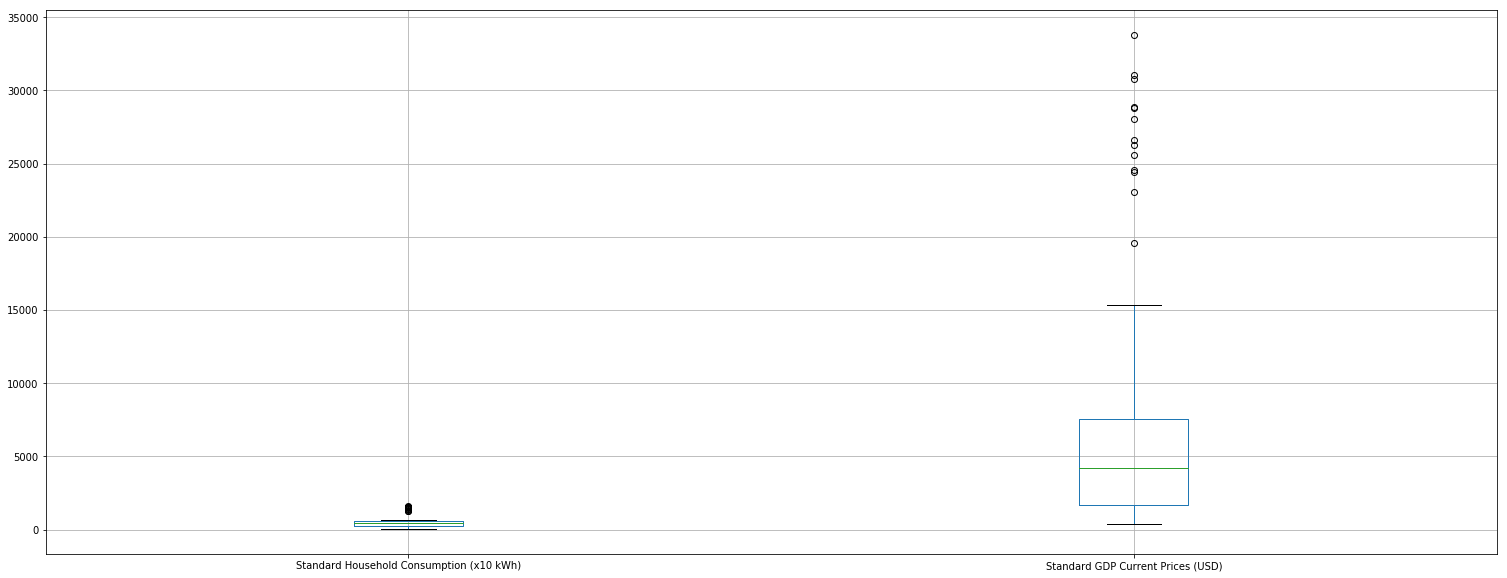

In [78]:
result1[['Standard Household Consumption (x10 kWh)','Standard GDP Current Prices (USD)']].boxplot(figsize=(26, 10))

When analyzing the correlation between standard household consumption and standard GDP, North & South America and Asia show a higher correlation than the rest of the continents. In the case of Europe, values are more scattered and in the higher end of the graph due to a higher standard GDP. It can be concluded that the correlation between both variables although exists in all continents, vaires varies between continents in terms of its strength.

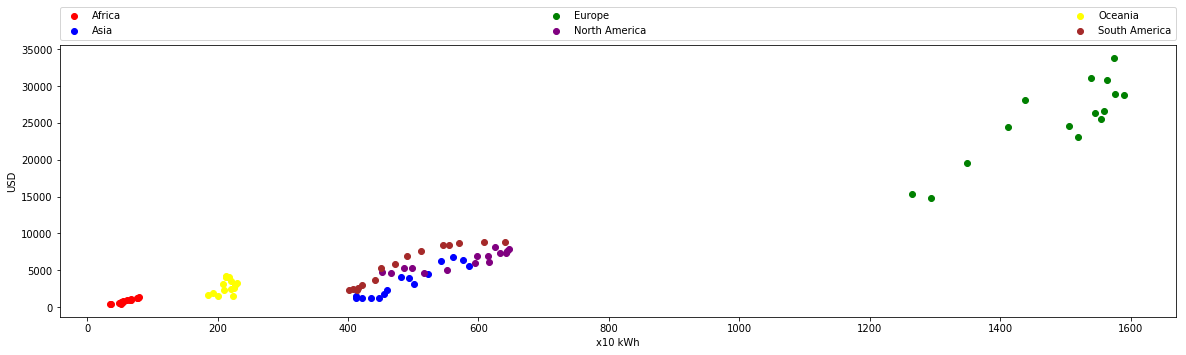

In [79]:


C = result1.index.levels[0]
colors = itertools.cycle(["r", "b", "g", 'purple','yellow','brown'])

plt.figure(figsize=(20, 5))

for cont in C :
    graph = result1.loc[cont]
    plt.scatter(x=graph['Standard Household Consumption (x10 kWh)'], y=graph['Standard GDP Current Prices (USD)'], color = next(colors), marker= 'o', label = cont)
plt.ylabel('USD')
plt.xlabel('x10 kWh')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

plt.show()

Further investigation depicts how the relationship of each of the raw variables (Household Consumption (GWh) and GDP) that form each of the standard variables differ. Additionally, within continents, it can be seen that the relationship between both consumption and GDP vs population behave in a similar way.
Especially notorious is the case of Africa, that shows how both GDP and electricity consumption grow with population. In this case although it could be infer due to the characteristics of its economy that the correlation between both is closer to 1, it can be seen how the slope is steeper than the unit due to the contribution of other factors to both variables.

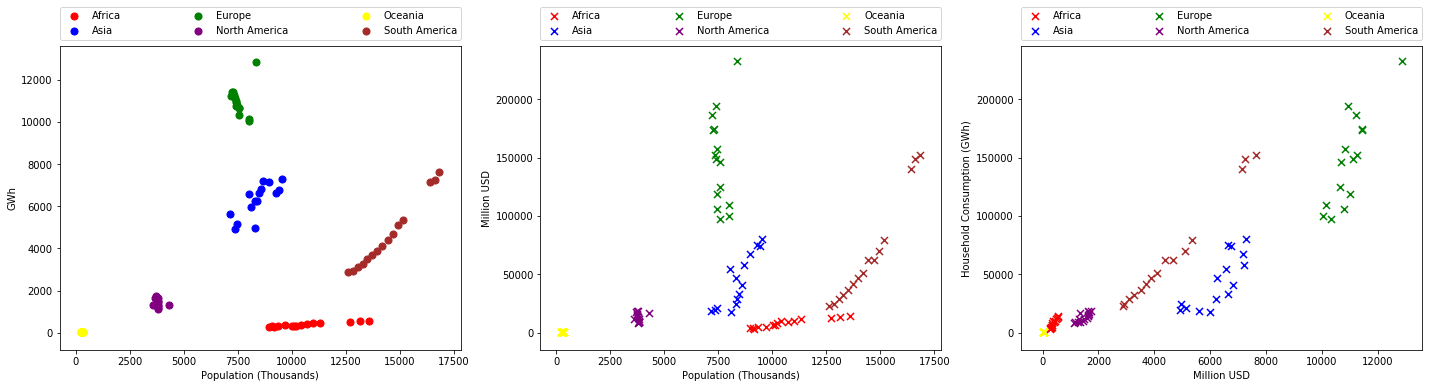

In [80]:
C = result1.index.levels[0]
colors = itertools.cycle(["r", "b", "g", 'purple','yellow','brown'])

plt.figure(figsize=(20, 5))


plt.subplot(1, 3, 1)
for cont in C :
    graph = result1.loc[cont]
    plt.scatter(x=graph['Population (Thousands)'], y=graph['Household Consumption (GWh)'], color = next(colors), marker = 'o', s = 50, label=cont)
plt.ylabel('GWh')
plt.xlabel('Population (Thousands)')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

#plt.ylim([20000, 160000])
#plt.title('Electricity consumption')
#plt.show()

plt.subplot(1, 3, 2)
for cont in C :
    graph = result1.loc[cont]
    plt.scatter(x=graph['Population (Thousands)'], y=graph['GDP Current Prices (Million USD)'], color = next(colors),marker = 'x', s = 50, label=cont)
plt.ylabel('Million USD')
plt.xlabel('Population (Thousands)')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

plt.subplot(1, 3, 3)
for cont in C :
    graph = result1.loc[cont]
    plt.scatter(x=graph['Household Consumption (GWh)'], y=graph['GDP Current Prices (Million USD)'], color = next(colors),marker = 'x', s = 50, label=cont)
plt.ylabel('Household Consumption (GWh)')
plt.xlabel('Million USD')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

plt.tight_layout()
plt.show()

As it can be seen from the graphs above, each continent follows a different pattern in terms ofstandard electricity consumption and standard GDP against population. Hence although initially, when considering global data, the relationship between both variables was high and positive, detailed analysis show how each continent behaves in a different way.

# Question 2: How has the economic welfare of countries evolved from the year 2000?

From the graphs below it can be seen that standard electricity consumption and standard GDP is higher in Europe than in the rest of the continents. In all cases both variables experience an increase during the period and except for Europe the increase seems to be smoother in the rest of the continents. 

From an electricity consumption perspective, the graph depicts how the economic downturns of 2008 impact the welfare of the population. It also shows how up until that year, when natural gas was considered an alternative cheaper solution for household heating systems, the population was relying on its use. The rest of the continents were more conservative in the use of electricity for household needs. It can be seen how there is a strong decrease in electricity consumption in 2002 and 2004 both in Asia and North America. The first change in slope can be seen in Asia in 2002 (due to the economic downturn that the country experienced that year). This decrease impacts North America in 2004 as part of its knock on effect. On the flpside, Europe decreases slightly its rate of increase but still increases the electricity consumption up until 2008. The economic Africa´s growth, in the lower-end is mainly due to the penetration of new electricity infrastructure during this period.

From a GDP perspective, the graph shows the deep impact that the 2008 economic downturn had in Europe. Although hiking up until then, the loss by 2014 was considerable in relative terms. For the rest of the continents, the 2002 economic downturn can be observed. It is worth mentining the economic acceleration that Asia has experimented during the period. Starting at a lower point than Oceania, it grows surpassing Oceania after 2006 and continues to grow at a higher rate than the rest of the continents. A similar growth is driven by South America but for different reasons. In this case it is not mainly the growth of the GDP but the decrease in population due to the crisis experienced by Argentina at the beginning of the century.

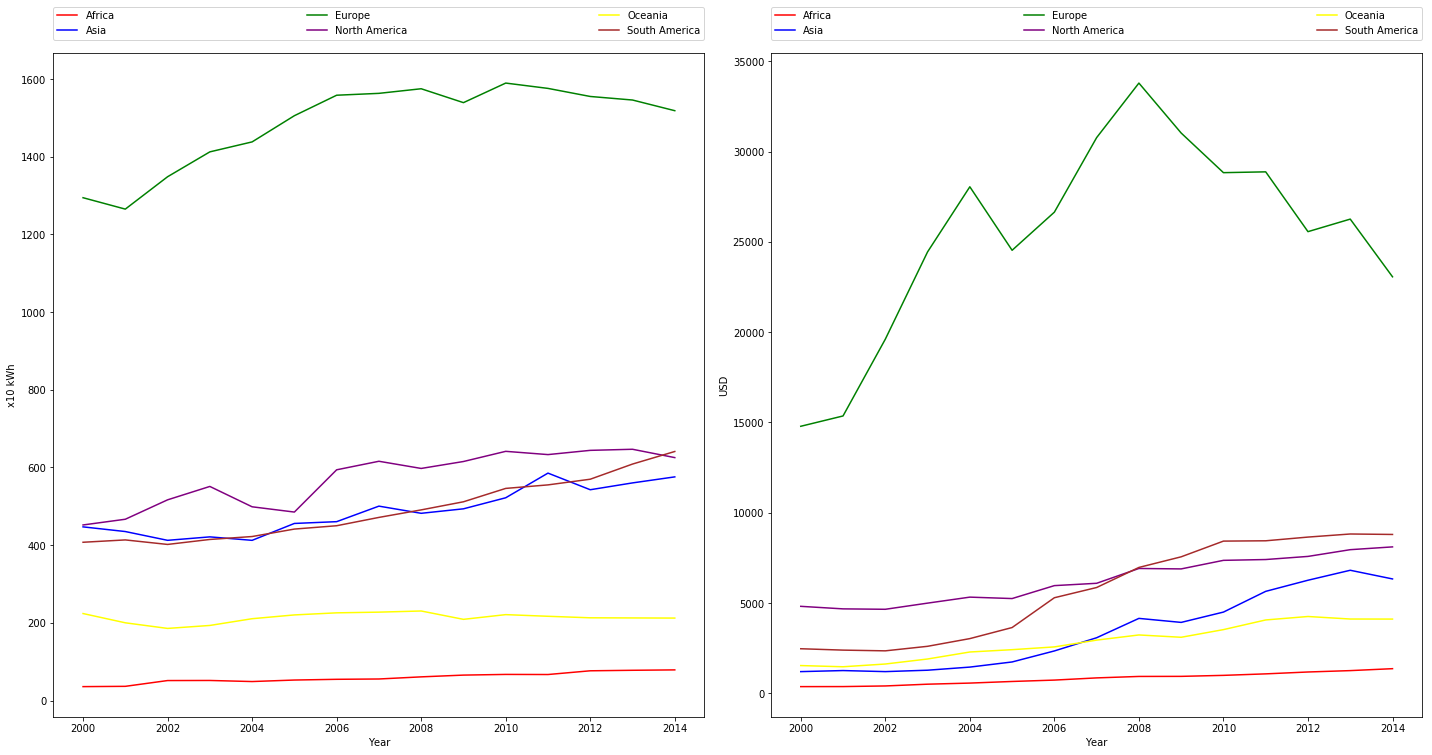

In [81]:
C = result1.index.levels[0]
colors = itertools.cycle(["r", "b", "g", 'purple','yellow','brown'])

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
for cont in C :
    graph = result1.loc[cont]
    plt.plot(graph.index, graph['Standard Household Consumption (x10 kWh)'], color = next(colors), linestyle = "-", label = cont)
plt.ylabel('x10 kWh')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

plt.subplot(1, 2, 2)
for cont in C :
    graph = result1.loc[cont]
    plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-", label = cont)
plt.ylabel('USD')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

plt.tight_layout()
plt.show()


# Question 3: What was the behavior of each continent during this period?

All six continents have increased their wealth during the period 2000-2014. Europe and America have more than doubled their GDP per capita while the rest of the continents have multiplied by 3 except for Asia that has multiplied by 7 its GDP.  All continents show a flat or declining GDP during the period 2002-2004, being the case of Asia the most significant.

All except for Europe and South America have experienced a slight decrease in its GDP due to the economic crisis if compared to Europe. It can be seen that Europe was one of the continents that was experiencing higher growth but also higher decline due to the crisis. In the case of America, periods of growth and slowdown have been alternating every two years.

Europe has been the continent that has experienced the highest economic downturn during the period. Although it was one of the highest growing ones up until 2008, the economic downturn has significantly reduced the GDP per capita up until more than USD10,000.

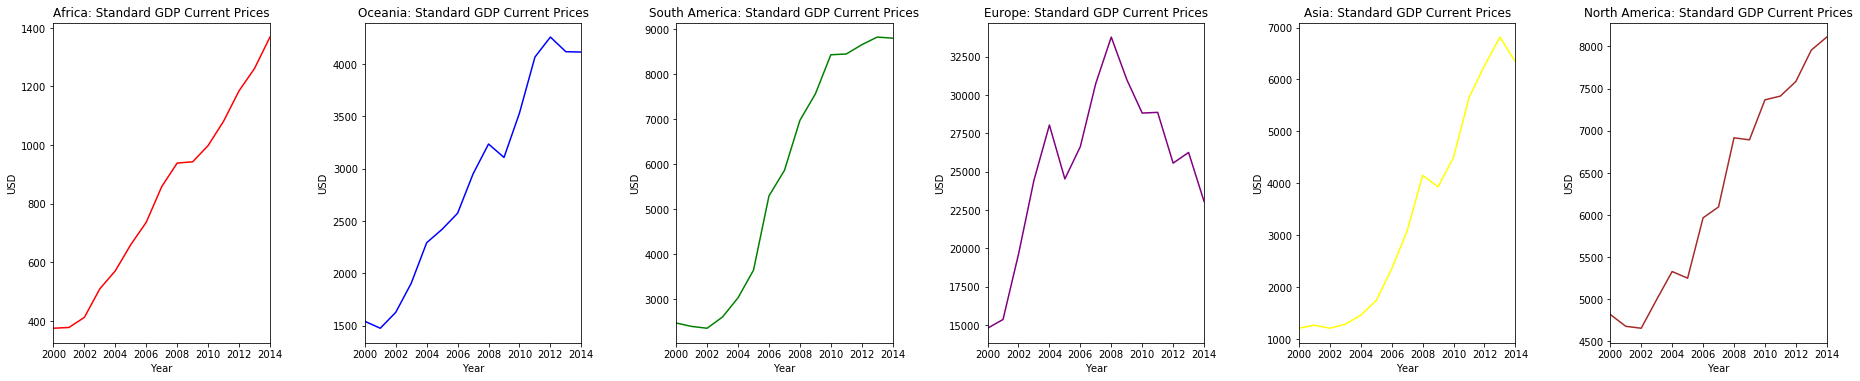

In [82]:
C = result1.index.levels[0]
colors = itertools.cycle(["r", "b", "g", 'purple','yellow','brown'])

plt.figure(figsize=(26, 10))

plt.subplot(2, 6, 1)

graph = result1.loc['Africa']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('Africa: Standard GDP Current Prices')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 2)

graph = result1.loc['Oceania']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('Oceania: Standard GDP Current Prices')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 3)

graph = result1.loc['South America']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('South America: Standard GDP Current Prices')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 4)

graph = result1.loc['Europe']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('Europe: Standard GDP Current Prices')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 5)
graph = result1.loc['Asia']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('Asia: Standard GDP Current Prices')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 6)
graph = result1.loc['North America']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('North America: Standard GDP Current Prices')
plt.xlim([2000, 2014])
plt.tight_layout()
plt.show()


Electricity consumption per household decreases in all continents between 2002 ad 2004. This is due to two main reasons. The increase of electricity prices correlated to and oil prices basket at that time and the economic slowdown that took place in that period. Although it shows an increase in all six continents, the behavior during the period under analysis is significantly different:

In Africa, electricity consumption decreases in 2004 and steadily increases during the period. After 2004 every 2 years Africa experiences a contraction in consumption followed by an increase that compensates and surpasses in absolute terms the contraction. Compared to the rest of the continents it seems too have the steepest slope only comparable to South America. This can be mainly because of the penetration of electricity infrastructure in the continent and its low starting point in terms of standard electricity consumption.

In Australia there is a decrease in consumption in 2002 and after a continuous increase up unitl 2008, it stabilizes around the value achieve in 2014. This is mainly due to the environmental and demand management regulation introduced in the country in 2006 added to the economic downturn that affected Australia in 2008.
In South America, there is a steady increase in electricity consumption due to the emigration after the recession at the beginning of the century.

In North America and Europe, electricity consumption growth is similar to Europe. In both there is a decrease in 2002-2004 due to the economic downturn in the case of Europe and to the introduction of natural gas and regulation giving positive incentives to the use of it in heating systems. Additionally, in North America the deregulation of household production makes the impact in this country higher than in Europe. In both, the main responsible for the 2008 decrease in electricity consumption is the real estate crisis that affected Europe more than America but it had its consequences in both.

In Asia, electricity consumption has followed an increasing path during the period. After the 2002-2004 stagnation in terms of consumption, the increase experienced by this region has been uneven. It has followed a pattern of two years of growth and one year of decrease. During the growth periods, it has increased its household consumption roughly 100 kWh per capita. During the declining periods, consumption has fall one quarter of its increase. 

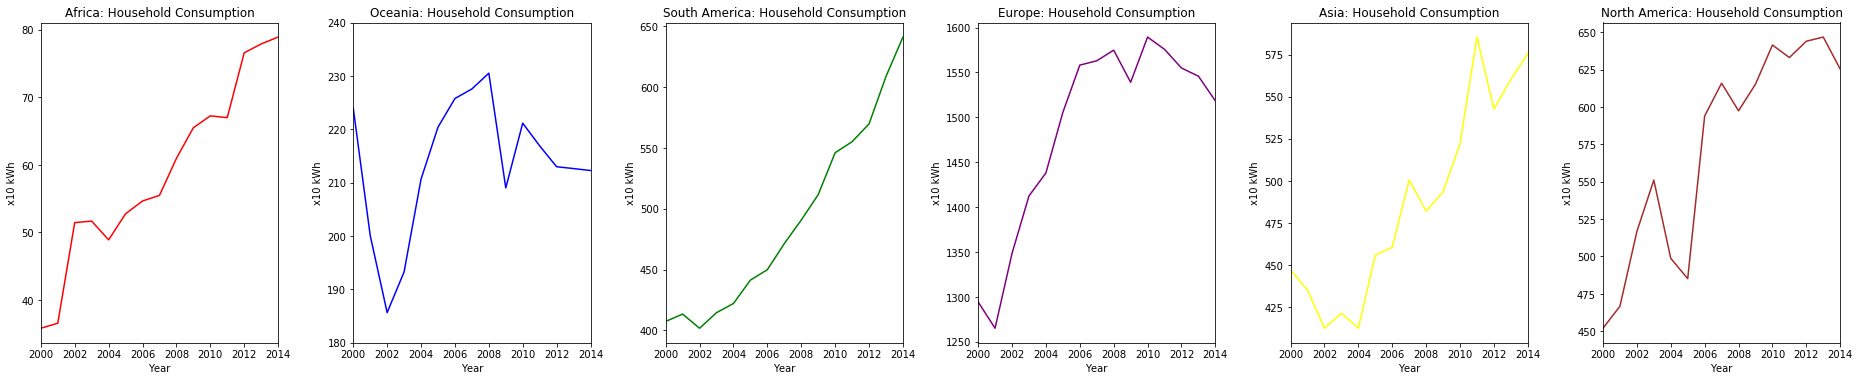

In [83]:
C = result1.index.levels[0]
colors = itertools.cycle(["r", "b", "g", 'purple','yellow','brown'])

plt.figure(figsize=(26, 10))

plt.subplot(2, 6, 1)

graph = result1.loc['Africa']
plt.plot(graph.index, graph['Standard Household Consumption (x10 kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('x10 kWh')
plt.xlabel('Year')
plt.title('Africa: Household Consumption')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 2)

graph = result1.loc['Oceania']
plt.plot(graph.index, graph['Standard Household Consumption (x10 kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('x10 kWh')
plt.xlabel('Year')
plt.title('Oceania: Household Consumption')
plt.xlim([2000, 2014])
plt.ylim([180, 240])

plt.subplot(2, 6, 3)

graph = result1.loc['South America']
plt.plot(graph.index, graph['Standard Household Consumption (x10 kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('x10 kWh')
plt.xlabel('Year')
plt.title('South America: Household Consumption')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 4)

graph = result1.loc['Europe']
plt.plot(graph.index, graph['Standard Household Consumption (x10 kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('x10 kWh')
plt.xlabel('Year')
plt.title('Europe: Household Consumption')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 5)
graph = result1.loc['Asia']
plt.plot(graph.index, graph['Standard Household Consumption (x10 kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('x10 kWh')
plt.xlabel('Year')
plt.title('Asia: Household Consumption')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 6)
graph = result1.loc['North America']
plt.plot(graph.index, graph['Standard Household Consumption (x10 kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('x10 kWh')
plt.xlabel('Year')
plt.title('North America: Household Consumption')
plt.xlim([2000, 2014])

plt.tight_layout()
plt.show()

Although there is no consistent data available for 20014-2017, there are several questions to be analysed as next steps:

1. What has happened during this period in terms of economic and consumption growth? What is the impact of new demand management regulation introduced in each country and is there a true effect on consumption?

2. What would be the projection of the electricity consumption and economic growth for the different continents based on the previous years? How does it compare to the potential growth based on other factors?

3. Can countries be clustered in a different way and not only at a continent level based on its electricity consumption and GDP? Are there any other variables that could be used to measure their true wealth and social welfare?

4. Can we compare the electricity consumption across economic sectors with the electricity production by energy source? What are the trends and how does the future look like.

Question 1 could be solved by using forecasting and time series techniques while question 2 would require NLP to analyse non-quantitative information coming from the country to adjust the economic values obtained in the analysis.
Question 3/4 would required clustering techniques to see which kind of cluster is the best to gain a deeper understanding of the correlation between social welfare and electricity consumption. Additionlly, the analysis could be extended from household consumption but all intensive-electricity-consumption sectors/verticals. Maybe it could be clustered using the electricity source and then move into each of the buckets the electricity consumption and predict the future using machie learning (regression, etc).